In [195]:
import pandas as pd
import os
import matplotlib
import collections
import re
import datetime

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers, utils
from sklearn import metrics, preprocessing

In [2]:
# Load dataframes

data_dir = os.path.join(os.getcwd(), "data")

links_path = os.path.join(data_dir, "links.csv")
movies_path = os.path.join(data_dir, "movies.csv")
ratings_path = os.path.join(data_dir, "ratings.csv")
tags_path = os.path.join(data_dir, "tags.csv")
tmdb_path = os.path.join(data_dir, "tmdb", "*")

df_tmdb_lst = []
import glob
tmbd_files = glob.glob(tmdb_path)
for file in tmbd_files:
    data = pd.read_json(file, lines=True)
    df_tmdb_lst.append(data)

df_tmdb = pd.concat(df_tmdb_lst, ignore_index=True) 
df_tmdb.drop("status", axis=1, inplace=True)

df_links = pd.read_csv(links_path)
df_movies = pd.read_csv(movies_path)
df_ratings = pd.read_csv(ratings_path)
df_tags = pd.read_csv(tags_path)

<Axes: title={'center': 'Distribution of Ratings'}, xlabel='Rating', ylabel='Counts'>

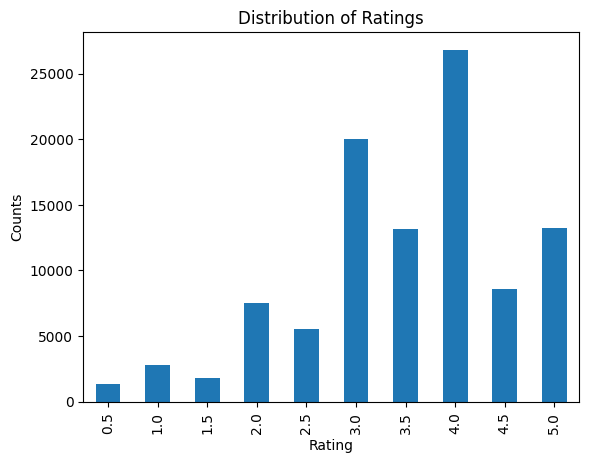

In [24]:
df_ratings["rating"].value_counts().sort_index().plot(kind='bar', title="Distribution of Ratings", 
                                                      xlabel="Rating", ylabel="Counts")

<Axes: title={'center': 'Distribution of Average Movie Ratings'}, xlabel='Average Rating', ylabel='Frequency'>

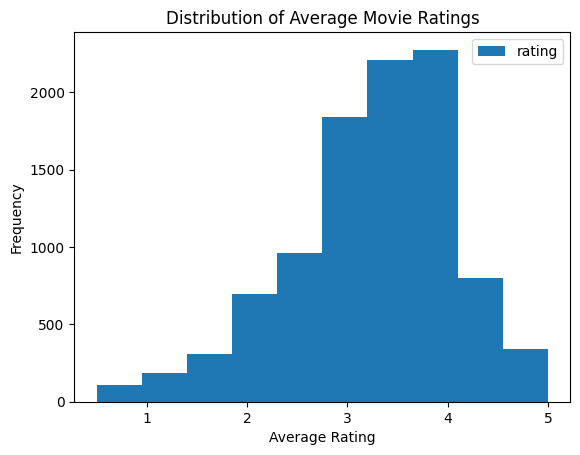

In [44]:
# average movie rating

df_ratings[["movieId", "rating"]].groupby("movieId").mean().plot(kind='hist', title="Distribution of Average Movie Ratings", 
                                                      xlabel="Average Rating", ylabel="Frequency")

In [46]:
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


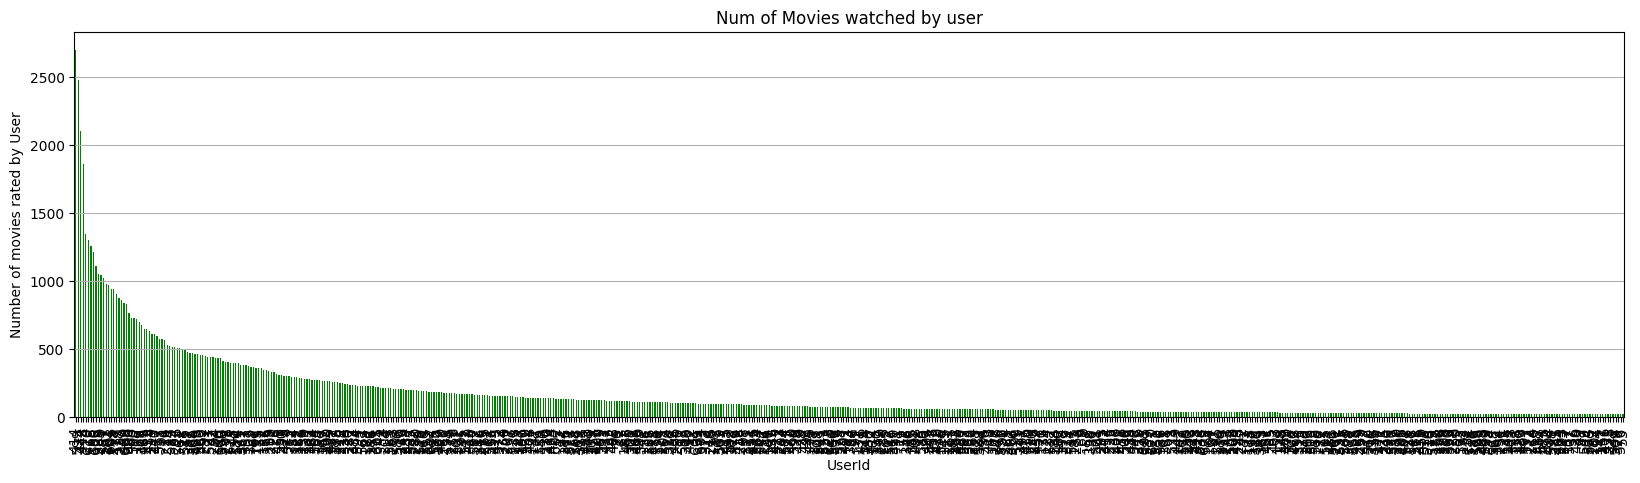

In [56]:
df_ratings.groupby("userId").count()["movieId"].sort_values(ascending=False).plot(
    kind="bar", color="green", title="Num of Movies watched by user", 
    xlabel="UserId", ylabel="Number of movies rated by User",
    figsize=(20,5)).grid(axis='y')

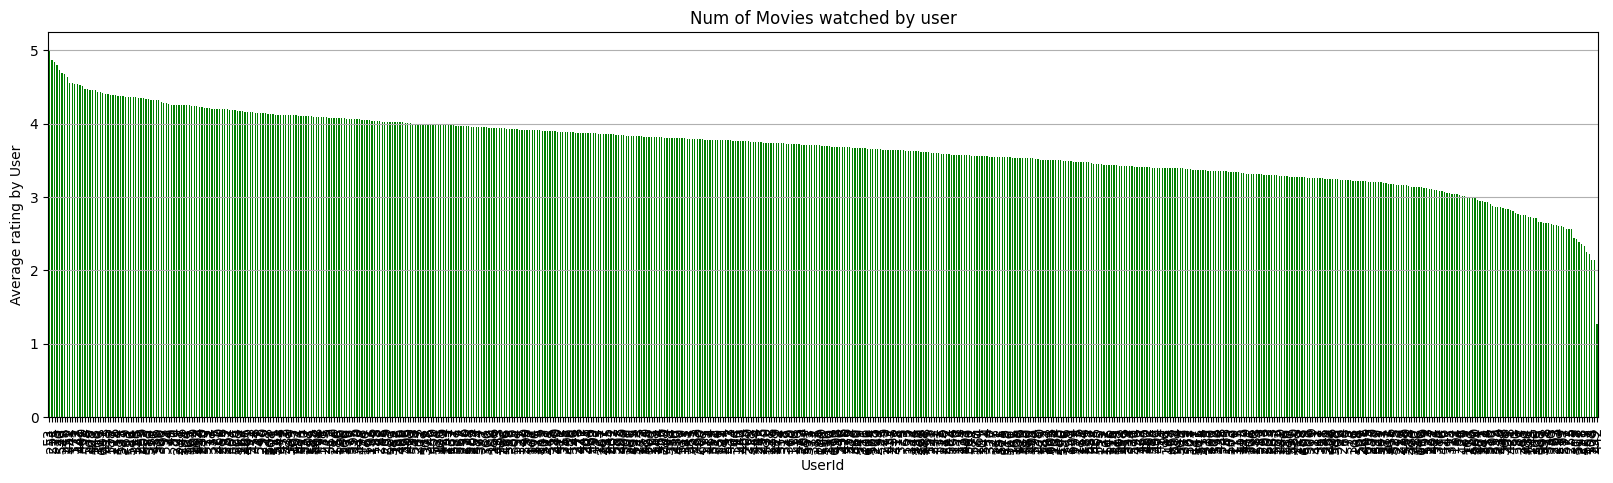

In [197]:
df_ratings.groupby("userId")["rating"].mean().sort_values(ascending=False).plot(
    kind="bar", color="green", title="Num of Movies watched by user", 
    xlabel="UserId", ylabel="Average rating by User",
    figsize=(20,5)).grid(axis='y')

In [85]:
# average user rating
lst = []
for threshold in [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]:
    lst.append((threshold, 
               (df_ratings.groupby("userId")["rating"].mean().sort_values(ascending=False)>=threshold).sum(),
               (df_ratings.groupby("userId")["rating"].mean().sort_values(ascending=False)<threshold).sum()))
    
df = pd.DataFrame(lst)
df.columns = ["Threshold", "#AvgUserRatings >= Threshold", "#AvgUserRatings < Threshold"]
df

,Threshold,#AvgUserRatings >= Threshold,#AvgUserRatings < Threshold
0,0.5,610,0
1,1.0,610,0
2,1.5,609,1
3,2.0,609,1
4,2.5,600,10
5,3.0,561,49
6,3.5,398,212
7,4.0,153,457
8,4.5,14,596
9,5.0,1,609


In [86]:
lst = []
for threshold in [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]:
    lst.append((threshold, 
               (df_ratings.groupby("movieId")["rating"].mean().sort_values(ascending=False)>=threshold).sum(),
               (df_ratings.groupby("movieId")["rating"].mean().sort_values(ascending=False)<threshold).sum()))
    
df = pd.DataFrame(lst)
df.columns = ["Threshold", "#AvgMovieRatings >= Threshold", "#AvgMovieRatings < Threshold"]
df

,Threshold,#AvgMovieRatings >= Threshold,#AvgMovieRatings < Threshold
0,0.5,9724,0
1,1.0,9616,108
2,1.5,9428,296
3,2.0,9088,636
4,2.5,8248,1476
5,3.0,6966,2758
6,3.5,4680,5044
7,4.0,2270,7454
8,4.5,719,9005
9,5.0,296,9428


<Axes: title={'center': 'Distribution of Average Movie Ratings'}, xlabel='Average Rating', ylabel='Frequency'>

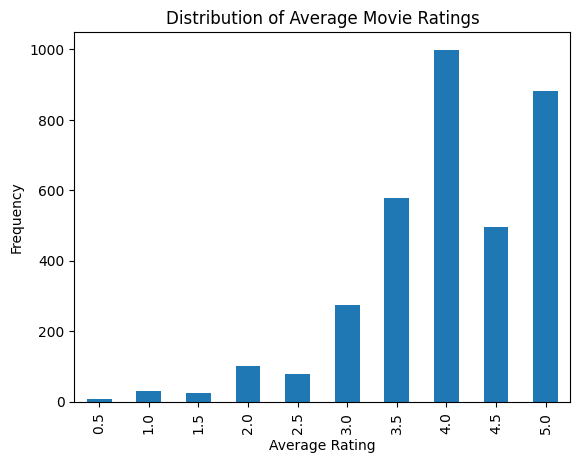

In [90]:
# tags are skewed towards highler rated movies.
(pd.merge(df_tags, df_ratings, on=["userId", "movieId"], how="left").rating.value_counts().sort_index().
         plot(kind='bar', title="Distribution of Average Movie Ratings", 
            xlabel="Average Rating", ylabel="Frequency")
)

In [168]:
(pd.merge(df_ratings[["movieId", "rating"]], 
          df_movies.set_index("movieId")['genres'].str.split('|').reset_index())[["rating", "genres"]].
 explode("genres").genres.value_counts()
)

genres
Drama                 41928
Comedy                39053
Action                30635
Thriller              26452
Adventure             24161
Romance               18124
Sci-Fi                17243
Crime                 16681
Fantasy               11834
Children               9208
Mystery                7674
Horror                 7291
Animation              6988
War                    4859
IMAX                   4145
Musical                4138
Western                1930
Documentary            1219
Film-Noir               870
(no genres listed)       47
Name: count, dtype: int64

In [175]:
df_tmdb["spoken_languages"].str.split("|").explode().value_counts()

spoken_languages
en    8456
fr     996
es     755
de     566
it     540
      ... 
am       1
co       1
lt       1
tt       1
uz       1
Name: count, Length: 109, dtype: int64

In [183]:
df_tmdb.cast.str.split("|").explode().value_counts().sort_values(ascending=False)

cast
Robert De Niro       62
Samuel L. Jackson    60
Bruce Willis         57
Nicolas Cage         51
Morgan Freeman       49
                     ..
Kenyon Wells          1
Daniel McArthur       1
Rebecca Thurmond      1
James Iddings         1
Esther Garrel         1
Name: count, Length: 18320, dtype: int64

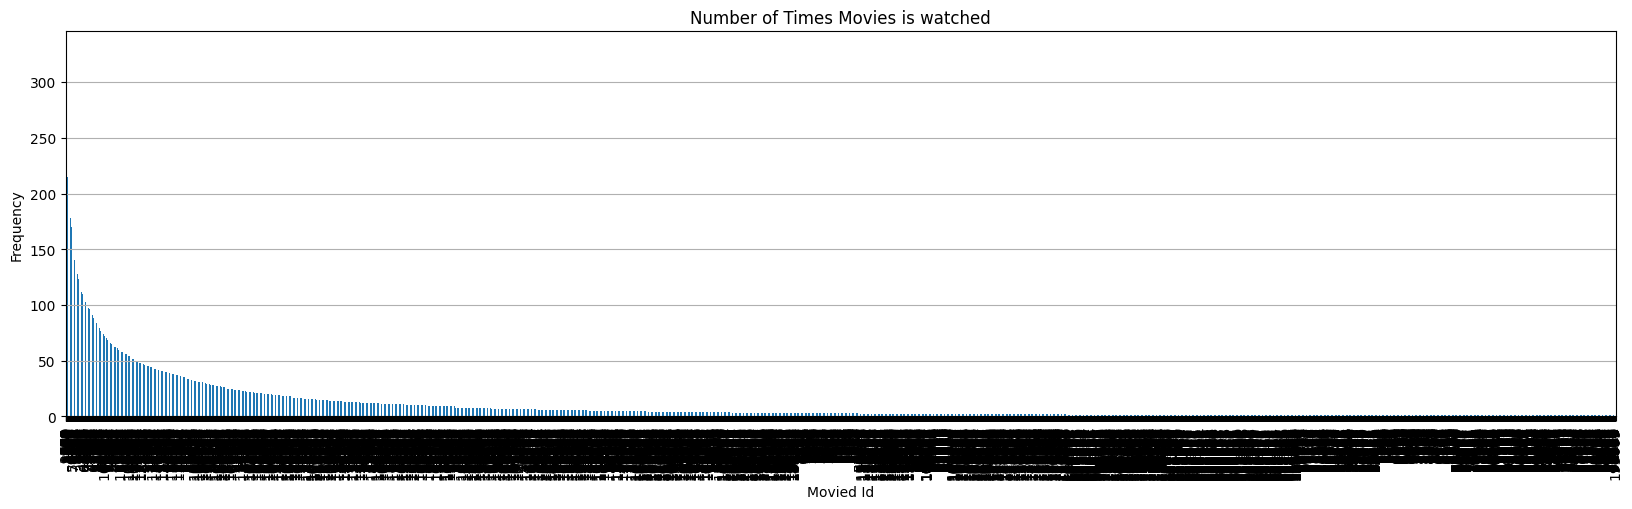

In [209]:
pd.merge(df_movies, df_ratings)["movieId"].value_counts().plot(kind='bar', title="Number of Times Movies is watched", 
            xlabel="Movied Id", ylabel="Frequency", figsize=(20,5)).grid(axis='y')

In [215]:
df_ratings["movieId"].value_counts().reset_index()

,movieId,count
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
...,...,...
9719,86279,1
9720,86922,1
9721,5962,1
9722,87660,1


In [220]:
df = pd.merge(df_tmdb, df_ratings["movieId"].value_counts().reset_index(), left_on="id", right_on="movieId")

In [222]:
df[["count"]]

0       21
1        2
2        1
3        3
4        1
        ..
1461     2
1462    30
1463     1
1464    43
1465     5
Name: count, Length: 1466, dtype: int64

In [238]:
df = pd.merge(pd.merge(df_tmdb, 
                  pd.merge(df_movies, df_links, on="movieId"), 
            left_on = "id", right_on = "tmdbId", how = "left"), 
         df_ratings["movieId"].value_counts().reset_index(), on="movieId")
df.head(1)

,overview,popularity,original_title,runtime,release_date,vote_average,vote_count,tagline,spoken_languages,cast,id,movieId,title,genres,imdbId,tmdbId,count
0,"The second ""visual album"" (a collection of sho...",8.738,Lemonade,65,2016-04-23,8.497,147,,en,Beyoncé|Jay-Z|Serena Williams|Zendaya|Quvenzha...,394269,169034,Lemonade (2016),(no genres listed),5662106,394269.0,1


In [309]:
import numpy

numpy.corrcoef(df["count"].values, df["vote_count"].values)

array([[1.        , 0.61251359],
       [0.61251359, 1.        ]])

In [258]:
df_by_cast = df[["count", "cast"]]
df_by_cast["cast"] = df_by_cast.cast.map(lambda x: x.split("|"))

/var/folders/jr/0nkdy85s131c0vzr2f_sf8f80000gn/T/ipykernel_60629/829409808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_cast["cast"] = df_by_cast.cast.map(lambda x: x.split("|"))


In [312]:
tmp = pd.get_dummies(pd.DataFrame(df_by_cast['cast'].tolist()).stack()).groupby(level=0).sum(0)
tmp_df = pd.concat([df_by_cast["count"], tmp], axis=1)

cols = list(tmp_df.columns)
cols.remove('count')
cols.remove('')
cols

from collections import defaultdict
import numpy as np

d = defaultdict(int)

for col in cols:
    sub_df = tmp_df[[col, "count"]]
    sub_df = sub_df[sub_df[col] != 0]
    d[col] = np.dot(np.array(sub_df[col].values), np.array(sub_df["count"].values))
    
counter = collections.Counter(d)
df_cast_by_number_of_movies_watched = pd.DataFrame(counter.most_common(20))
df_cast_by_number_of_movies_watched.columns = ["cast", "number_of_movies_watched"]

In [359]:
df_by_genre = df[["count", "genres"]]
df_by_genre["genres"] = df_by_genre.genres.map(lambda x: x.split("|"))


tmp = pd.get_dummies(pd.DataFrame(df_by_genre['genres'].tolist()).stack()).groupby(level=0).sum(0)
tmp_df = pd.concat([df_by_genre["count"], tmp], axis=1)

cols = list(tmp_df.columns)
cols.remove('count')
cols.remove('(no genres listed)')
cols

from collections import defaultdict
import numpy as np

d = defaultdict(int)

for col in cols:
    sub_df = tmp_df[[col, "count"]]
    sub_df = sub_df[sub_df[col] != 0]
    d[col] = np.dot(np.array(sub_df[col].values), np.array(sub_df["count"].values))
    
counter = collections.Counter(d)
df_genre_by_number_of_movies_watched = pd.DataFrame(counter.most_common(20))
df_genre_by_number_of_movies_watched.columns = ["genres", "number_of_movies_watched"]

/var/folders/jr/0nkdy85s131c0vzr2f_sf8f80000gn/T/ipykernel_60629/1920106404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_genre["genres"] = df_by_genre.genres.map(lambda x: x.split("|"))


In [361]:
df_genre_by_number_of_movies_watched

,genres,number_of_movies_watched
0,Drama,41776
1,Comedy,38988
2,Action,30532
3,Thriller,26372
4,Adventure,24068
5,Romance,18102
6,Sci-Fi,17109
7,Crime,16631
8,Fantasy,11767
9,Children,9203


In [362]:
df_tmdb

,overview,popularity,original_title,runtime,release_date,vote_average,vote_count,tagline,spoken_languages,cast,id
0,"The second ""visual album"" (a collection of sho...",8.738,Lemonade,65,2016-04-23,8.497,147,,en,Beyoncé|Jay-Z|Serena Williams|Zendaya|Quvenzha...,394269
1,"Set in 1929, a political boss and his advisor ...",17.518,Miller's Crossing,115,1990-09-21,7.455,1496,"Up is down, black is white, and nothing is wha...",en|ga|it|yi,Gabriel Byrne|Albert Finney|Jon Polito|Marcia ...,379
2,A student's premonition of a deadly rollercoas...,40.900,Final Destination 3,93,2006-02-09,6.081,3549,This ride will be the death of you.,en,Mary Elizabeth Winstead|Ryan Merriman|Kris Lem...,9286
3,"On Christmas Eve, three homeless people living...",21.095,東京ゴッドファーザーズ,93,2003-12-29,7.895,1076,Meet the ultimate dysfunctional family.,en|ja|es,Aya Okamoto|Yoshiaki Umegaki|Tohru Emori|Satom...,13398
4,A wily old codger matches wits with the King o...,12.456,Darby O'Gill and the Little People,93,1959-06-24,6.700,130,A touch O'Blarney... a heap O'Magic and A LOAD...,ga|en,Albert Sharpe|Janet Munro|Sean Connery|Jimmy O...,18887
...,...,...,...,...,...,...,...,...,...,...,...
9616,"In 1980s Italy, a relationship begins between ...",47.008,Call Me by Your Name,132,2017-09-01,8.165,11418,Is it better to speak or die?,fr|en|it,Timothée Chalamet|Armie Hammer|Michael Stuhlba...,398818
9617,An American journalist arrives in Berlin just ...,11.197,The Good German,108,2006-12-15,5.700,284,"If war is Hell, then what comes after?",zh|de|ru|en,George Clooney|Cate Blanchett|Tobey Maguire|Be...,182
9618,Admiral Frank Beardsley returns to New London ...,16.539,"Yours, Mine & Ours",90,2005-11-23,6.150,777,"18 kids, one house, no way.",en,Dennis Quaid|Rene Russo|Sean Faris|Danielle Pa...,13499
9619,With their father away as a chaplain in the Ci...,20.062,Little Women,115,1994-12-21,7.287,1120,The story that has lived in our hearts for gen...,en|de|fr,Winona Ryder|Gabriel Byrne|Trini Alvarado|Sama...,9587
